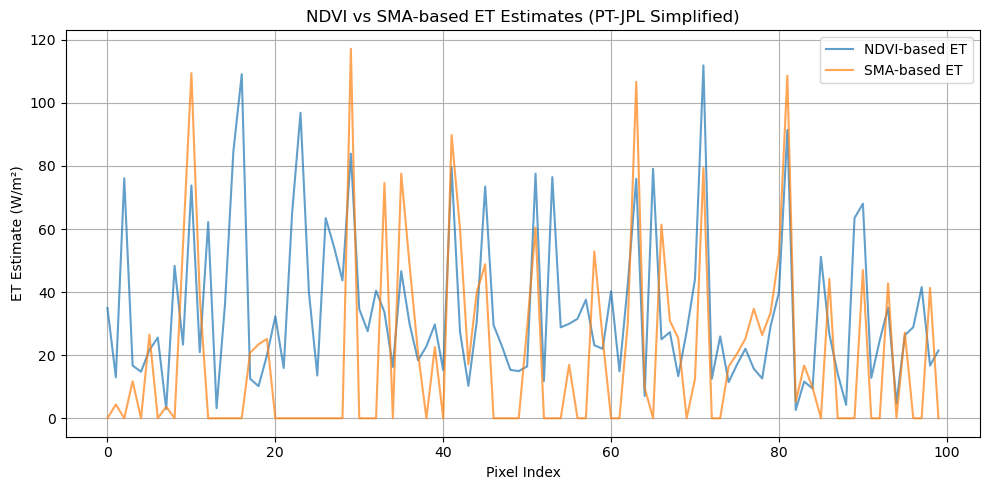

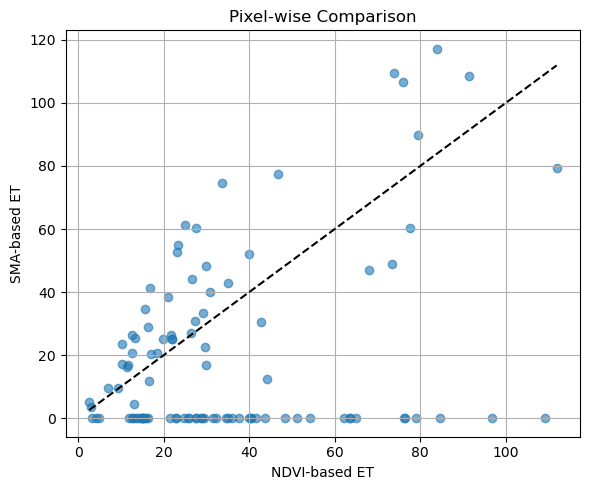

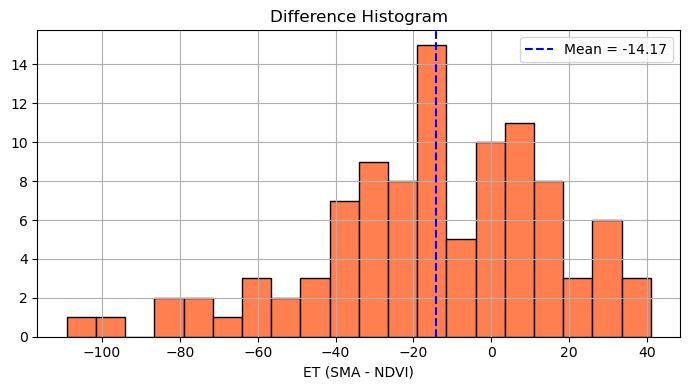

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Step 1: Simulate EMIT reflectance data ---
np.random.seed(42)
n_bands = 30  # e.g., 30 bands
n_pixels = 100
emit_data = np.random.rand(n_pixels, n_bands) * 0.5 + 0.2  # Simulated reflectance (0.2–0.7)

# --- Step 2: PCA ---
pca = PCA(n_components=3)
emit_pca = pca.fit_transform(emit_data)

# --- Step 3: Simulate endmembers (3 class spectra) ---
# Assume endmembers are [Soil, Vegetation, Shadow]
endmembers = np.array([
    [0.3, 0.2, 0.1],  # Soil
    [0.6, 0.5, 0.2],  # Vegetation
    [0.1, 0.1, 0.05]  # Shadow
])

# Solve for fractions via linear least squares: SMA
fractions = []
for i in range(emit_pca.shape[0]):
    f, _, _, _ = np.linalg.lstsq(endmembers.T, emit_pca[i], rcond=None)
    f = np.clip(f, 0, 1)  # constrain fractions
    f /= f.sum() if f.sum() > 0 else 1
    fractions.append(f)

fractions = np.array(fractions)
veg_frac_sma = fractions[:, 1]  # second entry = vegetation

# --- Step 4: NDVI mockup (random values for comparison) ---
ndvi = np.random.rand(n_pixels) * 0.5 + 0.4  # range 0.4–0.9

# --- Step 5: Simulate PT-JPL ET model ---
# ET = fVeg * NetRad * exp(-VPD) * f(Ts) — simplified
net_rad = np.random.uniform(400, 600, n_pixels)  # W/m²
vpd = np.random.uniform(1, 3, n_pixels)  # kPa
lst = np.random.uniform(295, 310, n_pixels)  # K

def f_temp(T):
    return np.exp(-((T - 303) ** 2) / (2 * 4**2))

et_sma = veg_frac_sma * net_rad * np.exp(-vpd) * f_temp(lst)
et_ndvi = ndvi * net_rad * np.exp(-vpd) * f_temp(lst)

# --- Step 6: Compare ET Estimates ---
plt.figure(figsize=(10, 5))
plt.plot(et_ndvi, label="NDVI-based ET", alpha=0.7)
plt.plot(et_sma, label="SMA-based ET", alpha=0.7)
plt.xlabel("Pixel Index")
plt.ylabel("ET Estimate (W/m²)")
plt.title("NDVI vs SMA-based ET Estimates (PT-JPL Simplified)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 7: Scatter + difference map ---
plt.figure(figsize=(6, 5))
plt.scatter(et_ndvi, et_sma, alpha=0.6)
plt.plot([et_ndvi.min(), et_ndvi.max()], [et_ndvi.min(), et_ndvi.max()], 'k--')
plt.xlabel("NDVI-based ET")
plt.ylabel("SMA-based ET")
plt.title("Pixel-wise Comparison")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
diff = et_sma - et_ndvi
plt.hist(diff, bins=20, color='coral', edgecolor='k')
plt.axvline(diff.mean(), color='blue', linestyle='--', label=f"Mean = {diff.mean():.2f}")
plt.xlabel("ET (SMA - NDVI)")
plt.title("Difference Histogram")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
